We want to predict median

In [3]:
from keras.datasets import boston_housing
(X_train, y_train), (X_test, y_test) = boston_housing.load_data()

In [4]:
X_train.shape, X_test.shape

((404, 13), (102, 13))

In [5]:
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train-mean)/std
X_test = (X_test-mean)/std
# keras.utils.normalize(x_test, axis=1)

In [4]:
from keras.layers import Dense
from keras.models import Sequential

def build():
    model = Sequential([
        Dense(64, activation='relu',input_shape=(len(X_train[1]),)),
        Dense(64, activation='relu'),
        Dense(1)
    ]) 
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae']) # Mean Absolute Error
    return model

In [ ]:
# TO ENABLE GPU
#import tensorflow as tf

#config = tf.compat.v1.ConfigProto()
#config.gpu_options.allow_growth = True
#config.gpu_options.visible_device_list = "0"
#tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))
# small batch size make GPU training poor!
# !nvidia-smi

In [8]:
# K-fold validation
import numpy as np
k = 4
num_val_samples = len(X_train) // k
epochs = 500
# all_scores = []
all_mae_histories = []

for i in range(k):
    print(f'Processing fold: #{i+1}')
    X_val = X_train[num_val_samples*i : num_val_samples*(i+1)]
    y_val = y_train[num_val_samples*i : num_val_samples*(i+1)]
    
    X_train_part = np.concatenate([X_train[:num_val_samples*i], X_train[num_val_samples*(i+1):]],axis=0)
    y_train_part = np.concatenate([y_train[:num_val_samples*i], y_train[num_val_samples*(i+1):]],axis=0)
    model = build()
    history = model.fit(X_train_part, y_train_part, epochs=epochs, batch_size=16, verbose=0, validation_data=(X_val, y_val)) # verbose = 0; training in "silent" mode
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

    # val_mse, val_mae = model.evaluate(X_val, y_val, verbose=0)
    # all_scores.append(val_mae)

# val_mae, np.mean(all_scores)
avg_mae_history = [np.mean([h[i] for h in all_mae_histories]) for i in range(epochs)]
#avg_mae_history

Processing fold: #1
Processing fold: #2
Processing fold: #3
Processing fold: #4


<b>Interpretation of mae.</b>.
If mae=3.0 then we deviate from the target value by 3000.

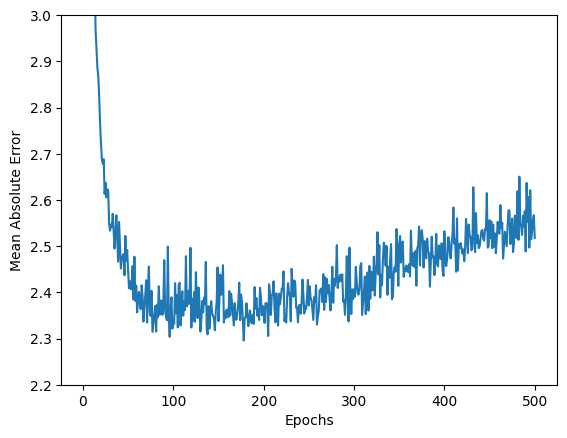

In [20]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1,epochs+1), avg_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.ylim(2.2,3)
plt.show()

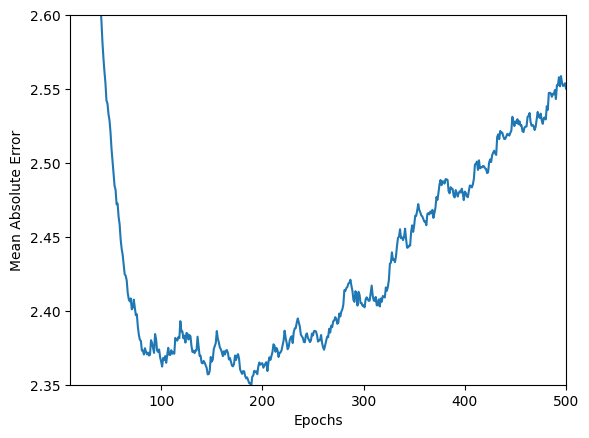

In [28]:
def smooth_plot(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_plot(avg_mae_history[10:])
plt.plot(np.arange(11,epochs+1), smooth_mae_history)
plt.xlim(10,epochs)
plt.ylim(2.35,2.6)
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.show()

Around 80 epochs MAE stops growing - we create the final model.

In [30]:
model = build()
model.fit(X_train, y_train, epochs=80, batch_size=16, verbose=0)

mse_score, mae_score = model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 1ms/step - loss: 24.3816 - mae: 3.2961


In [32]:
mae_score

3.2960641384124756